# Data Ingestion

Ok, so today we'll be working with the transactions, product, and hh_demographic tables in the project_data folder.

* First, we are reading in the transactions data, bringing in only the columns `household_key`, `BASKET_ID`, `DAY`, `PRODUCT_ID`, `QUANTITY`, and `SALES_VALUE`.

* We then convert `DAY`, `QUANTITY`, and `PRODUCT_ID` to the smallest appropriate integer types, upon ivestigation and assuming this is going to be a static dataset.


In [528]:
import pandas as pd
import numpy as np

In [529]:
transactions = pd.read_csv(
    "project_transactions.csv",
    usecols = ["household_key", "BASKET_ID", "DAY", "PRODUCT_ID", "QUANTITY", "SALES_VALUE"],
    #parse_dates = [""],
    dtype = {
        "household_key": "int16",
        "DAY": "int16",
        "PRODUCT_ID": "int32",
        "QUANTITY": "int32",
        "SALES_VALUE": "float32"
    }
).rename(columns = {'BASKET_ID': 'basket_id', 'DAY':'day', 'PRODUCT_ID': 'product_id', 'QUANTITY': 'quantity', 'SALES_VALUE':'sales_value'})

transactions.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2146311 entries, 0 to 2146310
Data columns (total 6 columns):
 #   Column         Dtype  
---  ------         -----  
 0   household_key  int16  
 1   basket_id      int64  
 2   day            int16  
 3   product_id     int32  
 4   quantity       int32  
 5   sales_value    float32
dtypes: float32(1), int16(2), int32(2), int64(1)
memory usage: 49.1 MB


In [530]:
transactions = (
    transactions
    # Creating 2016-01-01 and appending the time delta according to the previous 'day' column
    .assign(date = (pd.to_datetime("2016", format='%Y') 
                    + pd.to_timedelta(transactions["day"].sub(1).astype(str) + " days"))
           )
    .drop(["day"], axis=1)
)

In [531]:
transactions.head()

,household_key,basket_id,product_id,quantity,sales_value,date
0,1364,26984896261,842930,1,2.19,2016-01-01
1,1364,26984896261,897044,1,2.99,2016-01-01
2,1364,26984896261,920955,1,3.09,2016-01-01
3,1364,26984896261,937406,1,2.50,2016-01-01
4,1364,26984896261,981760,1,0.60,2016-01-01


In [532]:
transactions.isna().sum() # we have no NA values in our data frame

household_key    0
basket_id        0
product_id       0
quantity         0
sales_value      0
date             0
dtype: int64

## TIME BASED ANALYSIS

* How are sales going over time ? Are sales growing over time?
* Management is particularly interested in the dates from April 2016 and October 2017. Any observed trend in this period ?
* How was 2017 compared to 2016 ?
* How is the day of the week affecting the sales ?
  

<Axes: xlabel='date'>

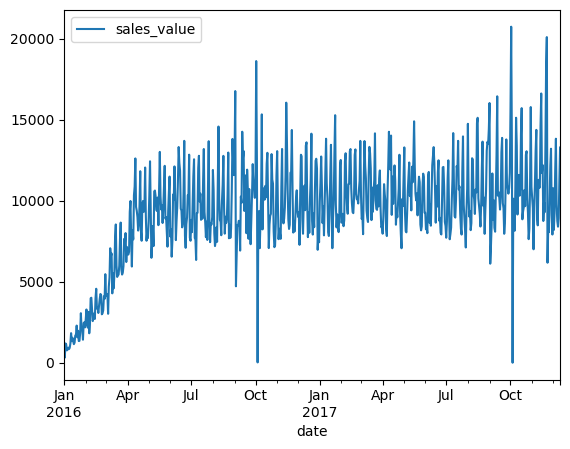

In [534]:
transactions.loc[:,["date", "sales_value"]].groupby("date").sum().plot()

<Axes: xlabel='date'>

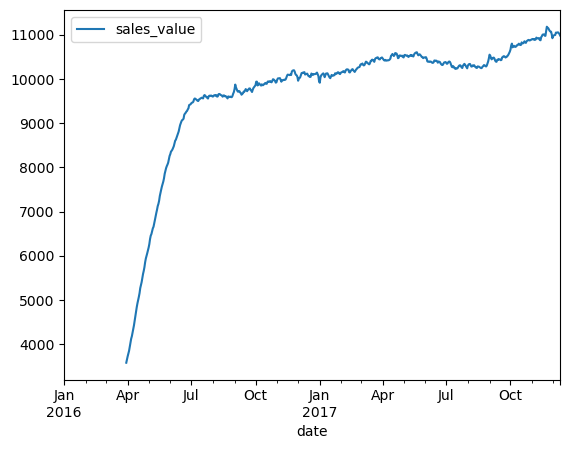

In [535]:
# Ploting the quarter rolling average of sales to see any trends
transactions.loc[:,["date", "sales_value"]].groupby("date").sum().rolling(90).mean().plot()
#We seethat there is a clear upward trend

<Axes: xlabel='date'>

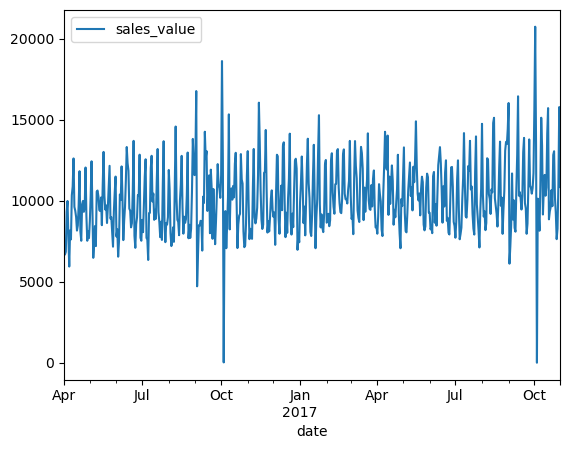

In [536]:
#Plotting the daily sum of sales for the requested period
transactions.groupby("date").agg({"sales_value": "sum"}).loc['2016-4':'2017-10'].plot()

<Axes: xlabel='date'>

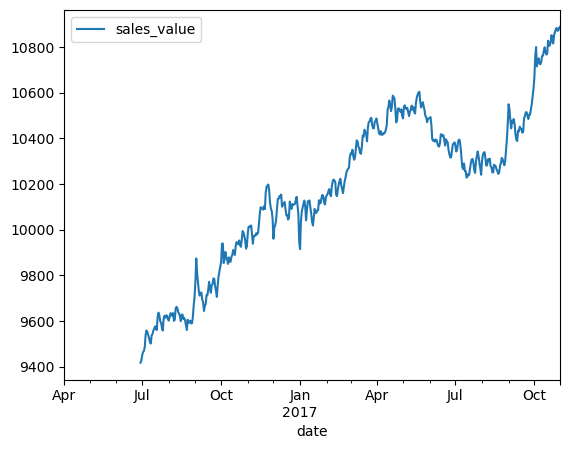

In [537]:
#Again, calculating the quarter rolling avg for this period
transactions.groupby("date").agg({"sales_value": "sum"}).loc['2016-4':'2017-10'].rolling(90).mean().plot()
#We actually observe a rapid increase in this time frame

In [538]:
### How was 2017 compared to 2016 ?

<Axes: xlabel='date'>

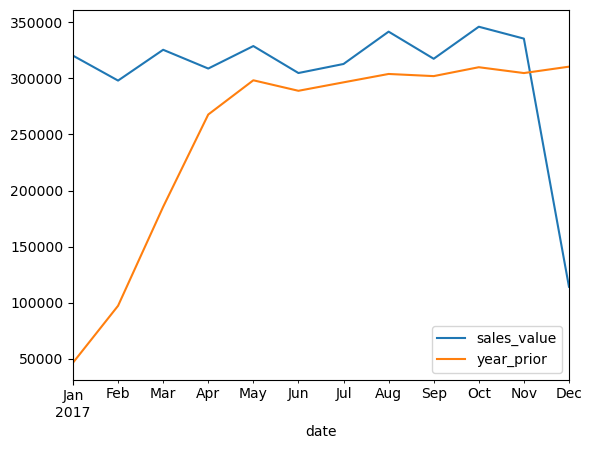

In [539]:
(transactions
 .set_index("date")
 .loc[:, ["sales_value"]]
 .resample("ME")
 .sum()
 .assign(year_prior = lambda x: x["sales_value"].shift(12))
 .loc["2017"]
 .plot()
)

<Axes: xlabel='date'>

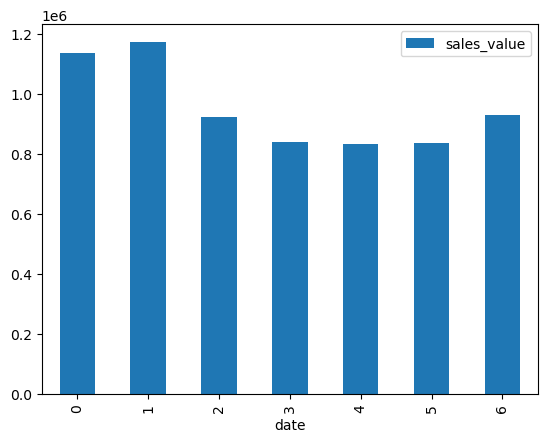

In [540]:
(transactions
 .groupby(transactions["date"].dt.dayofweek)
 .agg({"sales_value": "sum"})
 .plot.bar()
)

# DEMOGRAPHICS

* Reading in the `hh_demographic.csv` file, but only the columns `AGE_DESC`, `INCOME_DESC`, `household_key`, and `HH_COMP_DESC`. Converting the appropriate columns to the category dtype.


* Then we are joining with the transactions table by household_id, and calculate the sum of SALES VALUE by household_id.


* Once you've done that, join the demographics DataFrame to the aggregated transactions table. Since we're interested in analyzing the demographic data we have, make sure not to include rows from transactions that don't match.


* Plot the sum of sales by age_desc and income_desc (in separate charts).


* Which of our demographics have the highest average sales?


In [542]:
dem = pd.read_csv(
    "hh_demographic.csv",
    usecols = ["AGE_DESC", "INCOME_DESC", "household_key", "HH_COMP_DESC"],
    #parse_dates = [""],
    dtype = {
        "AGE_DESC": "category",
        "INCOME_DESC": "category",
        "household_key": "int16",
        "HH_COMP_DESC": "category"
    }
).rename(columns = {"AGE_DESC": "age_desc", "INCOME_DESC": "income_desc", "HH_COMP_DESC": "hh_comp_desc"})

dem.info(memory_usage="deep") 
# Parsing to 'category' brought the size of this dataframe from 180MB down to 6KB ! That's a huge memory optimization % wise !

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801 entries, 0 to 800
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   age_desc       801 non-null    category
 1   income_desc    801 non-null    category
 2   hh_comp_desc   801 non-null    category
 3   household_key  801 non-null    int16   
dtypes: category(3), int16(1)
memory usage: 6.0 KB


In [543]:
dem.head()

,age_desc,income_desc,hh_comp_desc,household_key
0,65+,35-49K,2 Adults No Kids,1
1,45-54,50-74K,2 Adults No Kids,7
2,25-34,25-34K,2 Adults Kids,8
3,25-34,75-99K,2 Adults Kids,13
4,45-54,50-74K,Single Female,16


In [544]:
dem.household_key.nunique()

801

In [545]:
#Joining transactions and demographics
trans_dem = transactions.merge(dem, how="left", on="household_key")
trans_dem.head()

,household_key,basket_id,product_id,quantity,sales_value,date,age_desc,income_desc,hh_comp_desc
0,1364,26984896261,842930,1,2.19,2016-01-01,65+,100-124K,Single Female
1,1364,26984896261,897044,1,2.99,2016-01-01,65+,100-124K,Single Female
2,1364,26984896261,920955,1,3.09,2016-01-01,65+,100-124K,Single Female
3,1364,26984896261,937406,1,2.50,2016-01-01,65+,100-124K,Single Female
4,1364,26984896261,981760,1,0.60,2016-01-01,65+,100-124K,Single Female


In [546]:
house_sales_agg = transactions.groupby("household_key").agg({"sales_value": "sum"})
house_sales_agg.head()

,sales_value
household_key,
1,4330.160156
2,1954.339966
3,2653.209961
4,1200.109985
5,779.059998


In [547]:
dem_w_sales = dem.merge(house_sales_agg, how="left", on="household_key")

In [548]:
dem_w_sales.isna().sum()

age_desc           0
income_desc        0
hh_comp_desc       0
household_key      0
sales_value      133
dtype: int64

In [549]:
#We have 133 households that have not performed any transactions

C:\Users\30698\AppData\Local\Temp\ipykernel_91976\460949626.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("age_desc")


<Axes: xlabel='age_desc'>

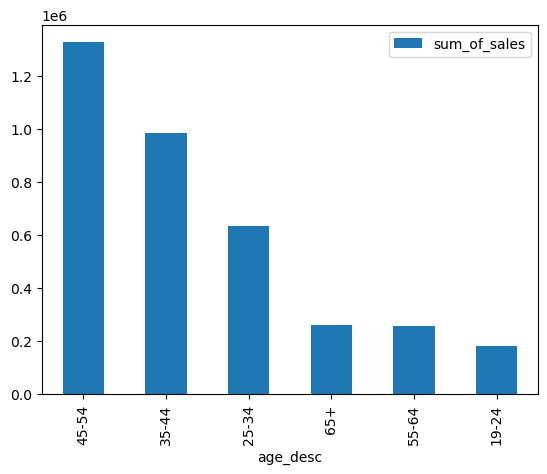

In [550]:
(
dem_w_sales
 .groupby("age_desc")
 .agg(sum_of_sales = ("sales_value", "sum"))
 .round()
 .sort_values(by="sum_of_sales", ascending=False)
 # .reset_index()
 .plot.bar()
 #.pie(y="age_desc", startangle=90)
 # .pivot(columns=["age_desc"])
)

C:\Users\30698\AppData\Local\Temp\ipykernel_91976\584639855.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("income_desc")


<Axes: xlabel='income_desc'>

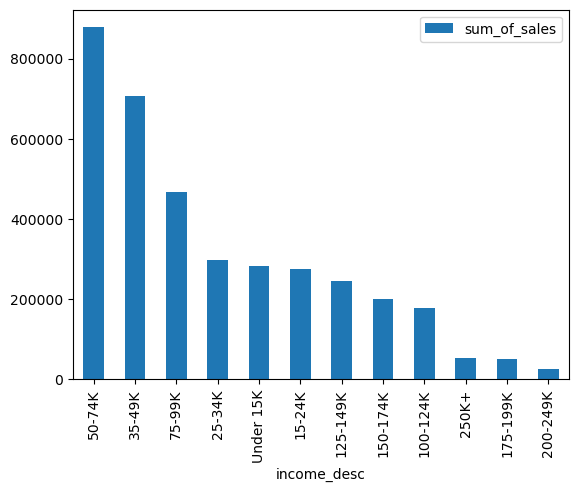

In [551]:
(
dem_w_sales
 .groupby("income_desc")
 .agg(sum_of_sales = ("sales_value", "sum"))
 .round()
 .sort_values(by="sum_of_sales", ascending=False)
 # .reset_index()
 .plot.bar()
 #.pie(y="age_desc", startangle=90)
 # .pivot(columns=["age_desc"])
)

In [552]:
# Creating a pivot table of the mean household sales by `AGE_DESC` and `HH_COMP_DESC`.

In [553]:
dem_w_sales.head()

,age_desc,income_desc,hh_comp_desc,household_key,sales_value
0,65+,35-49K,2 Adults No Kids,1,4330.160156
1,45-54,50-74K,2 Adults No Kids,7,3400.050049
2,25-34,25-34K,2 Adults Kids,8,5534.970215
3,25-34,75-99K,2 Adults Kids,13,13190.919922
4,45-54,50-74K,Single Female,16,1512.020020


In [554]:
dem_w_sales.pivot_table(
    index = "age_desc",
    columns = "hh_comp_desc",
    aggfunc = "mean",
    values = "sales_value",
    margins=True
).style.background_gradient(cmap="RdYlGn", axis=None)

C:\Users\30698\AppData\Local\Temp\ipykernel_91976\1123084663.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  dem_w_sales.pivot_table(


hh_comp_desc,1 Adult Kids,2 Adults Kids,2 Adults No Kids,Single Female,Single Male,Unknown,All
age_desc,,,,,,,
19-24,7268.796875,5428.945312,4020.800049,4576.095703,3216.834961,4911.274902,4692.077637
25-34,5512.196777,5753.973633,5638.515625,4807.440918,4909.522461,7356.270508,5435.517578
35-44,6297.737793,6691.772461,6260.412598,6015.192383,4844.191895,4227.691895,6090.556641
45-54,6632.568848,6610.484863,5839.526855,4549.365234,4636.637207,4843.995605,5534.879883
55-64,3064.869873,4695.654785,5752.413574,4816.148438,3922.546143,7973.750000,5168.923828
65+,4040.810059,5536.866699,4614.108398,4059.699463,3871.555908,2879.290039,4340.936523
All,6032.802246,6280.068848,5599.857910,4895.928223,4544.646973,4936.127930,5468.398926


# PRODUCT DEMOGRAPHICS

* Readin in the product csv file and only the product_id and department columns.

* Downcasting product id and turn department to category to optimize memory usage

* Joining all 3 tables to a single flat dataframe

* Pivoting the flat dataframe by AGE_DESC and DEPARTMENT, to answer below questions:
  ##### 1. What the sum of sales by age group and department ?
  ##### 2. Which category does our youngest demographic perform well in?
  



In [655]:
products = pd.read_csv(
    "product.csv",
    usecols = ["PRODUCT_ID", "DEPARTMENT"],
    dtype = {
        "PRODUCT_ID": "int32",
        "DEPARTMENT": "category"
    }
).rename(columns = {"PRODUCT_ID": "product_id", "DEPARTMENT": "department"})

products.head()

,product_id,department
0,25671,GROCERY
1,26081,MISC. TRANS.
2,26093,PASTRY
3,26190,GROCERY
4,26355,GROCERY


In [659]:
products.describe().round()

,product_id
count,92353.0
mean,5328353.0
std,5359937.0
min,25671.0
25%,970628.0
50%,1621091.0
75%,9704770.0
max,18316298.0


In [643]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92353 entries, 0 to 92352
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   product_id  92353 non-null  int16   
 1   department  92353 non-null  category
dtypes: category(1), int16(1)
memory usage: 272.1 KB


In [558]:
products.isna().sum()

product_id    0
department    0
dtype: int64

In [607]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2146311 entries, 0 to 2146310
Data columns (total 6 columns):
 #   Column         Dtype         
---  ------         -----         
 0   household_key  int16         
 1   basket_id      int64         
 2   product_id     int32         
 3   quantity       int32         
 4   sales_value    float32       
 5   date           datetime64[ns]
dtypes: datetime64[ns](1), float32(1), int16(1), int32(2), int64(1)
memory usage: 61.4 MB


In [663]:
flat_df = (transactions
           .merge(
               dem, 
               #how="inner", 
               left_on="household_key", 
               right_on="household_key"
           )
           .merge(
               products, 
               #how="inner", 
               left_on="product_id", 
               right_on="product_id"
           )
          )
flat_df.head()

,household_key,basket_id,product_id,quantity,sales_value,date,age_desc,income_desc,hh_comp_desc,department
0,1364,26984896261,842930,1,2.19,2016-01-01,65+,100-124K,Single Female,GROCERY
1,1364,26984896261,897044,1,2.99,2016-01-01,65+,100-124K,Single Female,GROCERY
2,1364,26984896261,920955,1,3.09,2016-01-01,65+,100-124K,Single Female,MEAT
3,1364,26984896261,937406,1,2.50,2016-01-01,65+,100-124K,Single Female,MEAT-PCKGD
4,1364,26984896261,981760,1,0.60,2016-01-01,65+,100-124K,Single Female,GROCERY


In [665]:
flat_df.info(memory_usage="deep", show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1161575 entries, 0 to 1161574
Data columns (total 10 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   household_key  1161575 non-null  int16         
 1   basket_id      1161575 non-null  int64         
 2   product_id     1161575 non-null  int32         
 3   quantity       1161575 non-null  int32         
 4   sales_value    1161575 non-null  float32       
 5   date           1161575 non-null  datetime64[ns]
 6   age_desc       1161575 non-null  category      
 7   income_desc    1161575 non-null  category      
 8   hh_comp_desc   1161575 non-null  category      
 9   department     1161575 non-null  category      
dtypes: category(4), datetime64[ns](1), float32(1), int16(1), int32(2), int64(1)
memory usage: 37.7 MB


In [669]:
(flat_df
 .pivot_table(
     index = "age_desc",
     columns = "department",
     values = "sales_value",
     aggfunc = "sum"
 ).T.style.background_gradient(cmap="RdYlGn", axis=1)
)

C:\Users\30698\AppData\Local\Temp\ipykernel_91976\4032687605.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  .pivot_table(


age_desc,19-24,25-34,35-44,45-54,55-64,65+
department,,,,,,
,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
AUTOMOTIVE,11.639999,21.250000,72.580002,55.919998,0.000000,16.369999
CHARITABLE CONT,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
CHEF SHOPPE,81.300003,134.160004,348.529999,418.239990,80.860001,149.240005
CNTRL/STORE SUP,2.000000,0.000000,1.000000,9.950000,2.000000,0.100000
COSMETICS,698.630005,2273.030029,4362.020020,5187.569824,986.260010,600.900024
COUP/STR & MFG,7.490000,48.419998,121.200005,154.550003,40.680000,20.490000
DAIRY DELI,3.800000,3.850000,7.390000,16.750000,3.140000,1.940000
DELI,4043.300049,18181.939453,34577.289062,44334.218750,9850.540039,10462.330078


# EXPORT

Exporting the pivot table to an excel file.

In [ ]:
(flat_df.pivot_table(index="department",
                            columns="age_desc",
                            values="sales_value",
                            aggfunc="sum")
 .style.background_gradient(cmap="RdYlGn", axis=1)
 .to_excel("demographic_category_sales.xlsx", sheet_name="sales_pivot")
)